In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
# Load dataset
df = pd.read_csv('fetal_health.csv')
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [6]:
# Remove duplicates
df.drop_duplicates(inplace=True)

<ipython-input-7-55c6b59ca8c2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['fetal_health'], palette='coolwarm')


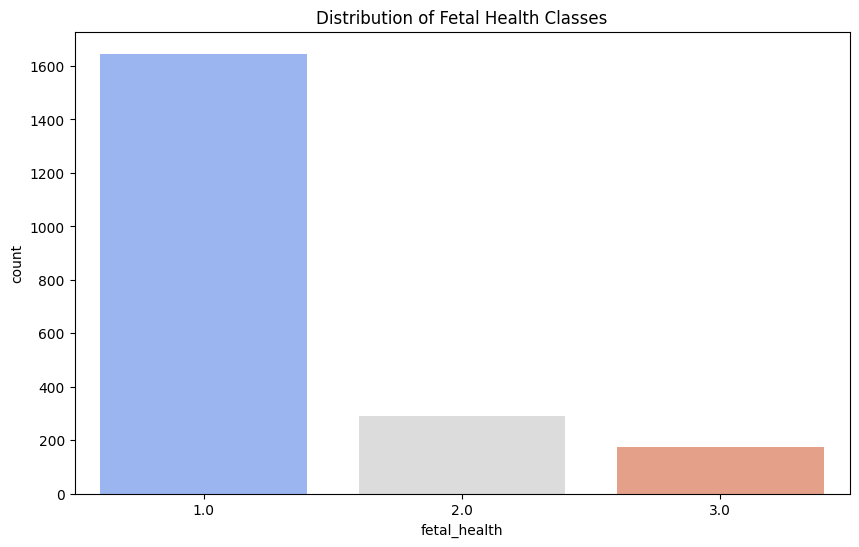

Inference: The dataset is imbalanced, requiring resampling techniques like SMOTE.


In [7]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.countplot(x=df['fetal_health'], palette='coolwarm')
plt.title('Distribution of Fetal Health Classes')
plt.show()
print("Inference: The dataset is imbalanced, requiring resampling techniques like SMOTE.")

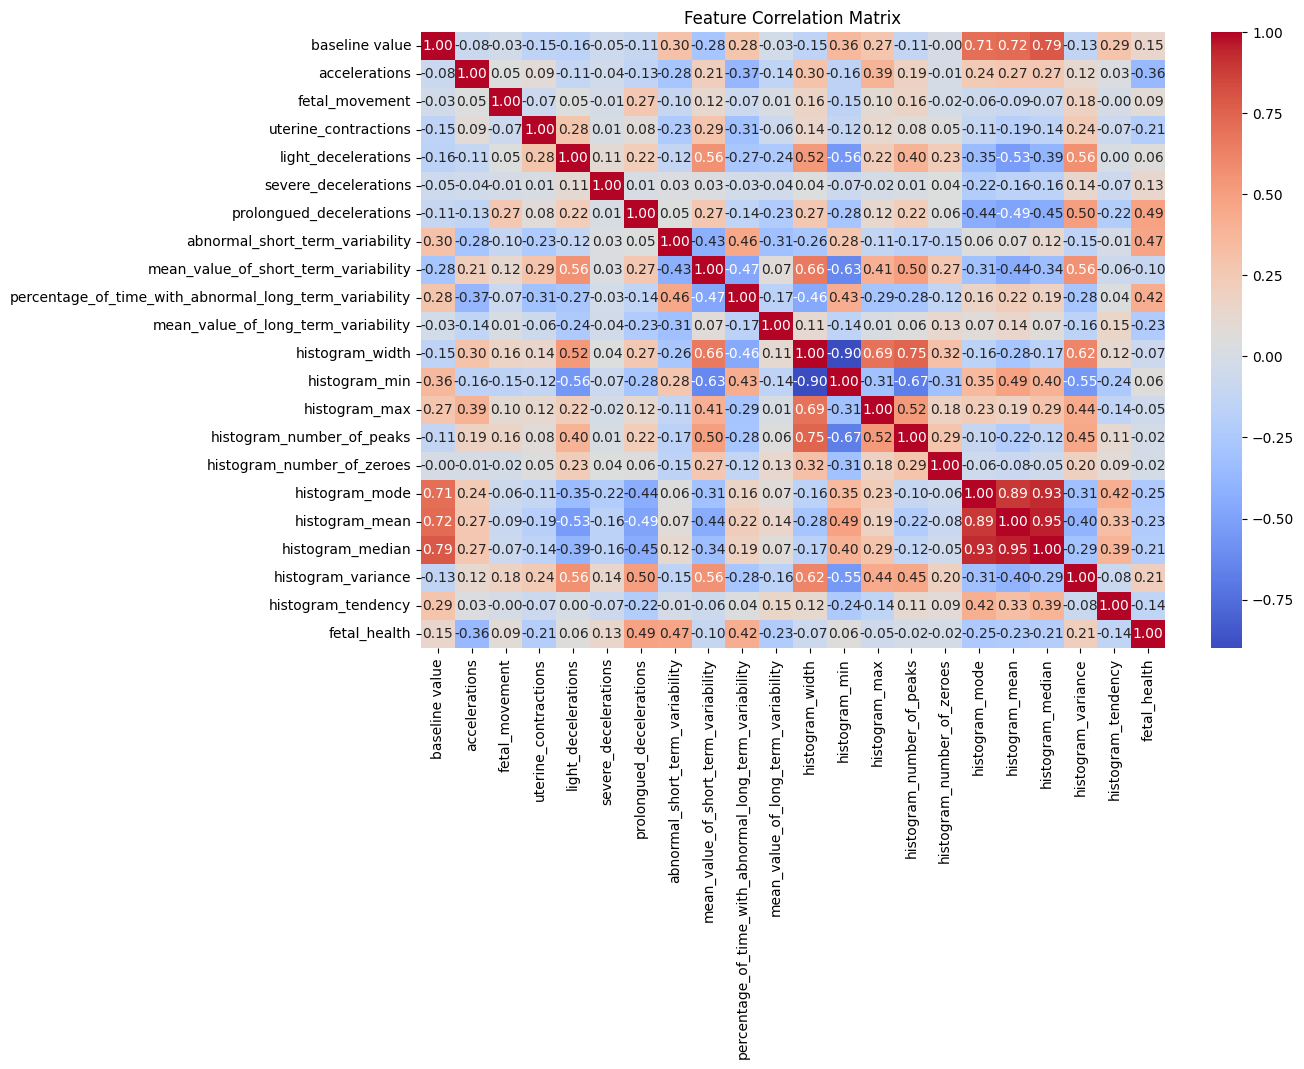

Key Inferences from Correlation Matrix (Fetal Health):

Strongest Predictors of Fetal Health (fetal_health):
Prolonged Decelerations (0.49)
Abnormal Short-Term Variability (0.47)
Percentage of Time with Abnormal Long-Term Variability (0.42)
Accelerations (0.36)

High Inter-Feature Correlations:
Histogram Mean & Median (0.95) and Mode (0.89–0.93) are nearly identical (likely redundant).
Light Decelerations & Histogram Width (0.52) and Number of Peaks (0.40).

Notable Negative Correlations:
Baseline Value is strongly inversely linked to:
Histogram Mode/Mean/Median (-0.71 to -0.79).
Fetal Health (-0.15).

Weak/Negligible Links to Fetal Health:
Fetal Movement (0.09), Severe Decelerations (0.13), Uterine Contractions (0.21).


In [8]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()
print("""Key Inferences from Correlation Matrix (Fetal Health):

Strongest Predictors of Fetal Health (fetal_health):
Prolonged Decelerations (0.49)
Abnormal Short-Term Variability (0.47)
Percentage of Time with Abnormal Long-Term Variability (0.42)
Accelerations (0.36)

High Inter-Feature Correlations:
Histogram Mean & Median (0.95) and Mode (0.89–0.93) are nearly identical (likely redundant).
Light Decelerations & Histogram Width (0.52) and Number of Peaks (0.40).

Notable Negative Correlations:
Baseline Value is strongly inversely linked to:
Histogram Mode/Mean/Median (-0.71 to -0.79).
Fetal Health (-0.15).

Weak/Negligible Links to Fetal Health:
Fetal Movement (0.09), Severe Decelerations (0.13), Uterine Contractions (0.21).""")

In [9]:
# Define features and target variable
x = df.drop(columns='fetal_health')
y = df['fetal_health']

# Feature Selection using RFE
rfe = RFE(RandomForestClassifier(n_estimators=50), n_features_to_select=10)
x_selected = rfe.fit_transform(x, y)

# Standardize features
scaler = StandardScaler()
x_selected = scaler.fit_transform(x_selected)

# Handle class imbalance using SMOTE
smote = SMOTE()
x_resampled, y_resampled = smote.fit_resample(x_selected, y)

# K-Fold Cross Validation (Stratified)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, min_samples_leaf=2)

# Lists to store metrics
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
conf_matrices = []

In [10]:
# Train and Evaluate Model
for i, (train_idx, test_idx) in enumerate(kfold.split(x_resampled, y_resampled)):
    x_train, x_test = x_resampled[train_idx], x_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    print(f"Fold {i+1}: Accuracy = {accuracy_scores[-1]:.4f}")

Fold 1: Accuracy = 0.9706
Fold 2: Accuracy = 0.9686
Fold 3: Accuracy = 0.9686
Fold 4: Accuracy = 0.9696
Fold 5: Accuracy = 0.9696


In [11]:
# Final Evaluation Metrics
print("\nFinal Evaluation Metrics (Average across folds):")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")


Final Evaluation Metrics (Average across folds):
Accuracy: 0.9694
Precision: 0.9694
Recall: 0.9694
F1 Score: 0.9694


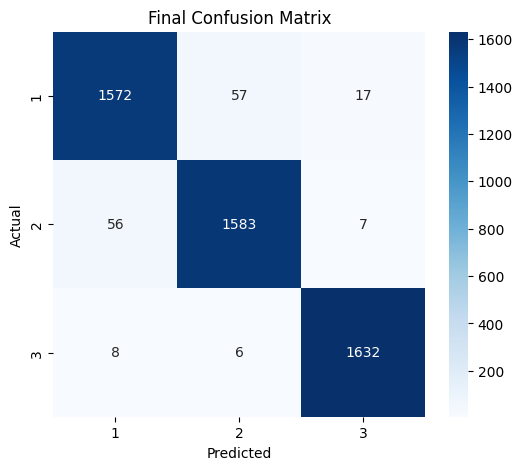

In [13]:
# Sum up confusion matrices from all folds
final_conf_matrix = np.sum(conf_matrices, axis=0)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Confusion Matrix')
plt.show()


In [25]:
# Get the selected feature names
selected_features = np.array(x.columns)[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: ['baseline value' 'accelerations' 'abnormal_short_term_variability'
 'mean_value_of_short_term_variability'
 'percentage_of_time_with_abnormal_long_term_variability'
 'mean_value_of_long_term_variability' 'histogram_width' 'histogram_mode'
 'histogram_mean' 'histogram_median']


In [16]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.5 MB/s eta 0:00:00


In [26]:
import gradio as gr
import numpy as np

# Predict function using the trained model and selected features
def predict_fetal_health(*features):
    try:
        # Convert input to NumPy array and reshape
        input_data = np.array(features, dtype=float).reshape(1, -1)

        # Scale using the fitted StandardScaler (on selected features)
        input_data_scaled = scaler.transform(input_data)

        # Predict using the trained model
        prediction = model.predict(input_data_scaled)[0]

        return {1: "Normal", 2: "Suspect", 3: "Pathological"}.get(prediction, "Unknown")
    except Exception as e:
        return f"Error: {e}"

# Create input fields for the selected features
inputs = [gr.Number(label=feature) for feature in selected_features]

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_fetal_health,
    inputs=inputs,
    outputs="text",
    title="Fetal Health Prediction",
    description="Enter the selected fetal health parameters to predict the health class."
)

# Launch the Gradio app
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f98061d6b7b64e64a8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
